In [1]:
import os
import sqlite3
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [2]:
def parse_bill_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    bill_data = {}
    bill_number_element = root.find('bill/number')
    if bill_number_element is None:
        bill_number_element = root.find('bill/billNumber')
    bill_type_element = root.find('bill/type')
    if bill_type_element is None:
        bill_type_element = root.find('bill/billType')
    if bill_number_element is None or bill_type_element is None:
        raise ValueError(f"Missing required elements in XML file: {file_path}")

    bill_data['bill_number'] = f"{bill_type_element.text}{bill_number_element.text}"

    congress_element = root.find("bill/congress")
    if congress_element is not None:
        bill_data['bill_congress'] = int(congress_element.text)

    bill_data['bill_type'] = bill_type_element.text

    title_element = root.find("bill/titles/item[titleType='Official Title as Introduced']/title")
    if title_element is None:
        raise ValueError(f"Missing 'title' element in XML file: {file_path}")
    bill_data['title'] = title_element.text

    version_element = root.find("version")
    if version_element is not None:
        bill_data['bill_version'] = version_element.text
    else:
        bill_data['bill_version'] = 'Unknown'

    # Attempt to find the sponsors element and proceed only if it's found and not empty
    sponsor_element = root.find("bill/sponsors/item")
    if sponsor_element is not None:
        sponsor_bioguide_id_element = sponsor_element.find("bioguideId")
        if sponsor_bioguide_id_element is not None:
            bill_data['sponsor_bioguide_id'] = sponsor_bioguide_id_element.text
        else:
            bill_data['sponsor_bioguide_id'] = 'Unknown'

        sponsor_full_name_element = sponsor_element.find("fullName")
        if sponsor_full_name_element is not None:
            bill_data['sponsor_full_name'] = sponsor_full_name_element.text
        else:
            bill_data['sponsor_full_name'] = 'Unknown'
    else:
        # Handle the case where no sponsor information is present
        bill_data['sponsor_bioguide_id'] = 'None'
        bill_data['sponsor_full_name'] = 'None'


    introduced_date_element = root.find("bill/introducedDate")
    if introduced_date_element is None:
        raise ValueError(f"Missing 'introduced_date' element in XML file: {file_path}")
    bill_data['introduced_date'] = introduced_date_element.text

    latest_action_date_element = root.find("bill/latestAction/actionDate")
    if latest_action_date_element is None:
        raise ValueError(f"Missing 'latest_action_date' element in XML file: {file_path}")
    bill_data['latest_action_date'] = latest_action_date_element.text

    latest_action_text_element = root.find("bill/latestAction/text")
    if latest_action_text_element is None:
        raise ValueError(f"Missing 'latest_action_text' element in XML file: {file_path}")
    bill_data['latest_action_text'] = latest_action_text_element.text

    policy_area_element = root.find("bill/policyArea/name")
    bill_data['policy_area'] = policy_area_element.text if policy_area_element is not None else 'Unknown'

    subject_elements = root.findall("bill/subjects/legislativeSubjects/item/name")
    bill_data['subjects'] = [subject_element.text for subject_element in subject_elements] if subject_elements else 'Unknown'

    cosponsor_elements = root.findall("bill/cosponsors/item/bioguideId")
    bill_data['cosponsors'] = [cosponsor_element.text for cosponsor_element in cosponsor_elements] if cosponsor_elements else 'Unknown'

    related_bills = []
    for related_bill in root.findall("bill/relatedBills/item"):
        related_bill_type = related_bill.find('type')
        related_bill_number = related_bill.find('number')
        if related_bill_type is not None and related_bill_number is not None:
            related_bills.append(f"{related_bill_type.text}{related_bill_number.text}")
        else:
            related_bills.append('Unknown')

    return bill_data, related_bills

In [3]:
# Set the root directory path
root_dir = "data/bill-info/"

# Connect to the SQLite database (it will be created if it doesn't exist)
conn = sqlite3.connect("data/bill_data.db")

# Create the bills table
conn.execute("""
    CREATE TABLE IF NOT EXISTS bills (
        bill_congress INTEGER,
        bill_type TEXT,
        bill_number TEXT,
        bill_version TEXT,
        title TEXT,
        sponsor_bioguide_id TEXT,
        sponsor_full_name TEXT,
        introduced_date TEXT,
        latest_action_date TEXT,
        latest_action_text TEXT,
        policy_area TEXT,
        subjects TEXT,
        cosponsors TEXT,
        PRIMARY KEY (bill_congress, bill_type, bill_number, bill_version)
    )
""")

# Create the related_bills table
conn.execute("""
    CREATE TABLE IF NOT EXISTS related_bills (
        bill_congress INTEGER,
        bill_type TEXT,
        bill_number TEXT,
        bill_version TEXT,
        related_bill_number TEXT,
        FOREIGN KEY (bill_number) REFERENCES bills (bill_number)
    )
""")

# Iterate over the congress directories
for congress in tqdm(os.listdir(root_dir), desc="Congress"):
    congress_dir = os.path.join(root_dir, congress)

    bills_data = []
    related_bills_data = []

    # Iterate over the bill type directories
    for bill_type in tqdm(os.listdir(os.path.join(congress_dir, "bills")), desc="Bill Type", leave=False):
        bill_type_dir = os.path.join(congress_dir, "bills", bill_type)

        # Iterate over the bill directories
        for bill_number in tqdm(os.listdir(bill_type_dir), desc="Bill Number", leave=False):
            bill_dir = os.path.join(bill_type_dir, bill_number)

            # Check if the required files exist
            if "fdsys_billstatus.xml" in os.listdir(bill_dir) and "fdsys_billstatus-lastmod.txt" in os.listdir(bill_dir):
                xml_file_path = os.path.join(bill_dir, "fdsys_billstatus.xml")
                try:
                    bill_data, related_bills = parse_bill_xml(xml_file_path)
                    bills_data.append(bill_data)
                    related_bills_data.extend([(bill_data['bill_congress'], bill_data['bill_type'], bill_data['bill_number'], bill_data['bill_version'], related_bill) for related_bill in related_bills])
                except ValueError as e:
                    print(f"Error: {str(e)}")
                    continue

    # Load data into DataFrames
    bills_df = pd.DataFrame(bills_data)
    #print("Debug: bills_df")
    #print(bills_df.head())

    related_bills_df = pd.DataFrame(related_bills_data, columns=['bill_congress', 'bill_type', 'bill_number', 'bill_version', 'related_bill_number'])
    #print("Debug: related_bills_df")
    #print(related_bills_df.head())

    bills_df['subjects'] = bills_df['subjects'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)
    bills_df['cosponsors'] = bills_df['cosponsors'].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

    # Insert data into the database
    bills_df.to_sql('bills', conn, if_exists='append', index=False)
    related_bills_df.to_sql('related_bills', conn, if_exists='append', index=False)

# Close the database connection
conn.close()

Congress:   0%|          | 0/6 [00:00<?, ?it/s]

Bill Type:   0%|          | 0/8 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/125 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/131 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/5885 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/784 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/3020 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/44 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/47 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/601 [00:00<?, ?it/s]

Debug: bills_df
  bill_number  bill_congress bill_type  \
0    HCONRES1            113   HCONRES   
1   HCONRES10            113   HCONRES   
2  HCONRES100            113   HCONRES   
3  HCONRES101            113   HCONRES   
4  HCONRES102            113   HCONRES   

                                               title bill_version  \
0  Regarding consent to assemble outside the seat...        3.0.0   
1  Supporting the goals and ideals of No Name-Cal...        3.0.0   
2  Authorizing the use of the rotunda of the Capi...        3.0.0   
3  Expressing the sense of Congress that Warren W...        3.0.0   
4  Expressing support for designation of June 21 ...        3.0.0   

  sponsor_bioguide_id                    sponsor_full_name introduced_date  \
0             S000250        Rep. Sessions, Pete [R-TX-32]      2013-01-03   
1             R000435  Rep. Ros-Lehtinen, Ileana [R-FL-27]      2013-01-25   
2             F000455      Rep. Fudge, Marcia L. [D-OH-11]      2014-05-22   
3   

Bill Type:   0%|          | 0/8 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/183 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/108 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/6526 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/957 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/3548 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/58 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/41 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/642 [00:00<?, ?it/s]

Debug: bills_df
  bill_number  bill_congress bill_type  \
0    HCONRES1            114   HCONRES   
1   HCONRES10            114   HCONRES   
2  HCONRES100            114   HCONRES   
3  HCONRES101            114   HCONRES   
4  HCONRES102            114   HCONRES   

                                               title bill_version  \
0  Regarding consent to assemble outside the seat...        3.0.0   
1  Recognizing the challenges and burdens associa...        3.0.0   
2  Expressing the sense of the Congress regarding...        3.0.0   
3  Supporting the Association of American Veterin...        3.0.0   
4  Providing for a joint session of Congress to r...        3.0.0   

  sponsor_bioguide_id               sponsor_full_name introduced_date  \
0             S000250   Rep. Sessions, Pete [R-TX-32]      2015-01-06   
1             F000043     Rep. Fattah, Chaka [D-PA-2]      2015-01-27   
2             R000580  Rep. Roskam, Peter J. [R-IL-6]      2015-12-01   
3             Y000065   

Bill Type:   0%|          | 0/8 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/149 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/146 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/7394 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/1187 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/3805 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/59 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/69 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/747 [00:00<?, ?it/s]

Debug: bills_df
  bill_number  bill_congress bill_type  \
0    HCONRES1            115   HCONRES   
1   HCONRES10            115   HCONRES   
2  HCONRES100            115   HCONRES   
3  HCONRES101            115   HCONRES   
4  HCONRES102            115   HCONRES   

                                               title bill_version  \
0  Regarding consent to assemble outside the seat...        3.0.0   
1  Expressing the sense of the Congress that tax-...        3.0.0   
2  Providing for a correction in the enrollment o...        3.0.0   
3  Providing for a joint session of Congress to r...        3.0.0   
4  Authorizing the use of Emancipation Hall in th...        3.0.0   

  sponsor_bioguide_id                        sponsor_full_name  \
0             S000250            Rep. Sessions, Pete [R-TX-32]   
1             P000594              Rep. Paulsen, Erik [R-MN-3]   
2             F000372  Rep. Frelinghuysen, Rodney P. [R-NJ-11]   
3             A000055        Rep. Aderholt, Robert B

Bill Type:   0%|          | 0/8 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/128 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/110 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/9062 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/1273 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/5086 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/52 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/82 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/808 [00:00<?, ?it/s]

Debug: bills_df
  bill_number  bill_congress bill_type  \
0    HCONRES1            116   HCONRES   
1   HCONRES10            116   HCONRES   
2  HCONRES100            116   HCONRES   
3  HCONRES101            116   HCONRES   
4  HCONRES102            116   HCONRES   

                                               title bill_version  \
0  Regarding consent to assemble outside the seat...        3.0.0   
1  Authorizing the use of the rotunda of the Capi...        3.0.0   
2  Urging the establishment of a United States Co...        3.0.0   
3  Expressing support for democratic elections in...        3.0.0   
4  Recognizing September 30, 2020, as a national ...        3.0.0   

  sponsor_bioguide_id                      sponsor_full_name introduced_date  \
0             M000312       Rep. McGovern, James P. [D-MA-2]      2019-01-03   
1             M001205         Rep. Miller, Carol D. [R-WV-3]      2019-01-30   
2             L000551            Rep. Lee, Barbara [D-CA-13]      2020-06-04

Bill Type:   0%|          | 0/8 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/125 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/106 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/9709 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/1532 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/5357 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/52 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/70 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/877 [00:00<?, ?it/s]

Debug: bills_df
  bill_number  bill_congress bill_type  \
0    HCONRES1            117   HCONRES   
1   HCONRES10            117   HCONRES   
2  HCONRES100            117   HCONRES   
3  HCONRES101            117   HCONRES   
4  HCONRES102            117   HCONRES   

                                               title bill_version  \
0  Regarding consent to assemble outside the seat...        3.0.0   
1  Permitting the remains of the late United Stat...        3.0.0   
2  Expressing the sense of Congress in opposition...        3.0.0   
3  Calling an Article V Convention for proposing ...        3.0.0   
4  Expressing the sense of Congress that it is th...        3.0.0   

  sponsor_bioguide_id                   sponsor_full_name introduced_date  \
0             M000312    Rep. McGovern, James P. [D-MA-2]      2021-01-04   
1             L000397         Rep. Lofgren, Zoe [D-CA-19]      2021-02-01   
2             Z000017        Rep. Zeldin, Lee M. [R-NY-1]      2022-07-14   
3       

Bill Type:   0%|          | 0/8 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/95 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/118 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/7579 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/1066 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/3893 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/30 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/63 [00:00<?, ?it/s]

Bill Number:   0%|          | 0/583 [00:00<?, ?it/s]

Debug: bills_df
  bill_number  bill_congress bill_type  \
0    HCONRES1            118   HCONRES   
1   HCONRES10            118   HCONRES   
2   HCONRES11            118   HCONRES   
3   HCONRES12            118   HCONRES   
4   HCONRES13            118   HCONRES   

                                               title bill_version  \
0  Regarding consent to assemble outside the seat...        3.0.0   
1  Expressing the sense of Congress that the Unit...        3.0.0   
2  Providing for a joint session of Congress to r...        3.0.0   
3  Expressing the sense of Congress that all dire...        3.0.0   
4            Supporting the Local Radio Freedom Act.        3.0.0   

  sponsor_bioguide_id                 sponsor_full_name introduced_date  \
0             C001053           Rep. Cole, Tom [R-OK-4]      2023-01-09   
1             T000165  Rep. Tiffany, Thomas P. [R-WI-7]      2023-01-25   
2             S001176      Rep. Scalise, Steve [R-LA-1]      2023-01-31   
3             C0

In [4]:
def preview_database(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    print("Bills Table Preview:")
    cursor.execute("""
        SELECT bill_number, bill_congress, bill_type, bill_version, title,
        introduced_date, sponsor_bioguide_id, sponsor_full_name,
        latest_action_date, latest_action_text, policy_area, subjects, cosponsors
        FROM bills
        LIMIT 5
    """)
    bills = cursor.fetchall()
    for bill in bills:
        print(f"Bill Number: {bill[0]}")
        print(f"Congress: {bill[1]}")
        print(f"Bill Type: {bill[2]}")
        print(f"Bill Version: {bill[3]}")
        print(f"Title: {bill[4]}")
        print(f"Introduced Date: {bill[5]}")
        print(f"Sponsor Bioguide ID: {bill[6]}")
        print(f"Sponsor Full Name: {bill[7]}")
        print(f"Latest Action Date: {bill[8]}")
        print(f"Latest Action Text: {bill[9]}")
        print(f"Policy Area: {bill[10]}")
        print(f"Subjects: {bill[11]}")
        print(f"Cosponsors: {bill[12]}")
        print("------------------------")

    print("\nTotal Bills Count:")
    cursor.execute("SELECT COUNT(*) FROM bills")
    total_bills = cursor.fetchone()[0]
    print(f"Total Bills: {total_bills}")

    print("\nBills Count by Congress:")
    cursor.execute("SELECT bill_congress, COUNT(*) FROM bills GROUP BY bill_congress")
    bills_by_congress = cursor.fetchall()
    for congress, count in bills_by_congress:
        print(f"Congress {congress}: {count} bills")

    print("\nRelated Bills Preview:")
    cursor.execute("SELECT bill_congress, bill_type, bill_number, bill_version, related_bill_number FROM related_bills LIMIT 5")
    related_bills = cursor.fetchall()
    for bill_congress, bill_type, bill_number, bill_version, related_bill in related_bills:
        print(f"Bill Congress: {bill_congress}")
        print(f"Bill Type: {bill_type}")
        print(f"Bill Number: {bill_number}")
        print(f"Bill Version: {bill_version}")
        print(f"Related Bill Number: {related_bill}")
        print("------------------------")

    print("\nTotal Related Bills Count:")
    cursor.execute("SELECT COUNT(*) FROM related_bills")
    total_related_bills = cursor.fetchone()[0]
    print(f"Total Related Bills: {total_related_bills}")

    conn.close()

preview_database("data/bill_data.db")

Bills Table Preview:
Bill Number: HCONRES1
Congress: 113
Bill Type: HCONRES
Bill Version: 3.0.0
Title: Regarding consent to assemble outside the seat of government.
Introduced Date: 2013-01-03
Sponsor Bioguide ID: S000250
Sponsor Full Name: Rep. Sessions, Pete [R-TX-32]
Latest Action Date: 2013-01-04
Latest Action Text: Received in the Senate.
Policy Area: Congress
Subjects: Congressional operations and organization
Cosponsors: Unknown
------------------------
Bill Number: HCONRES10
Congress: 113
Bill Type: HCONRES
Bill Version: 3.0.0
Title: Supporting the goals and ideals of No Name-Calling Week in bringing attention to name-calling of all kinds and providing schools with the tools and inspiration to launch an on-going dialogue about ways to eliminate name-calling and bullying in their communities.
Introduced Date: 2013-01-25
Sponsor Bioguide ID: R000435
Sponsor Full Name: Rep. Ros-Lehtinen, Ileana [R-FL-27]
Latest Action Date: 2013-01-25
Latest Action Text: Referred to the House Comm

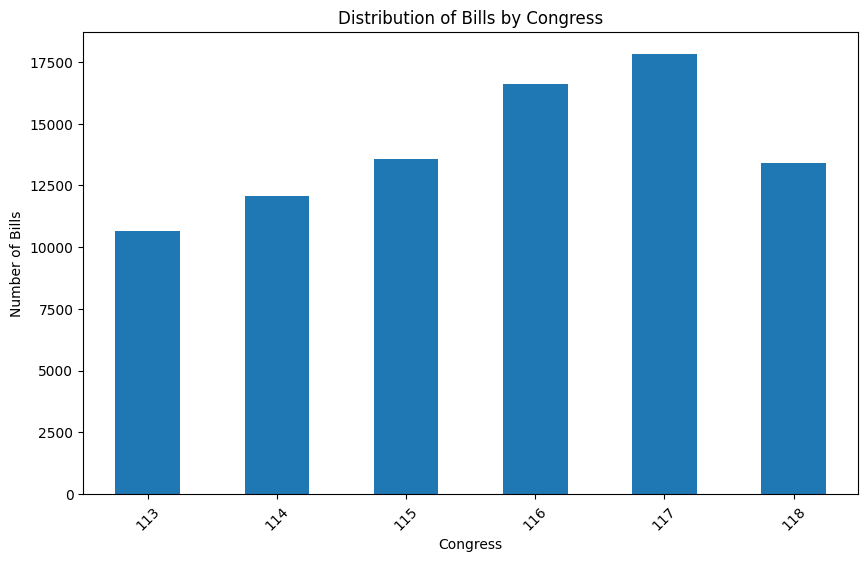

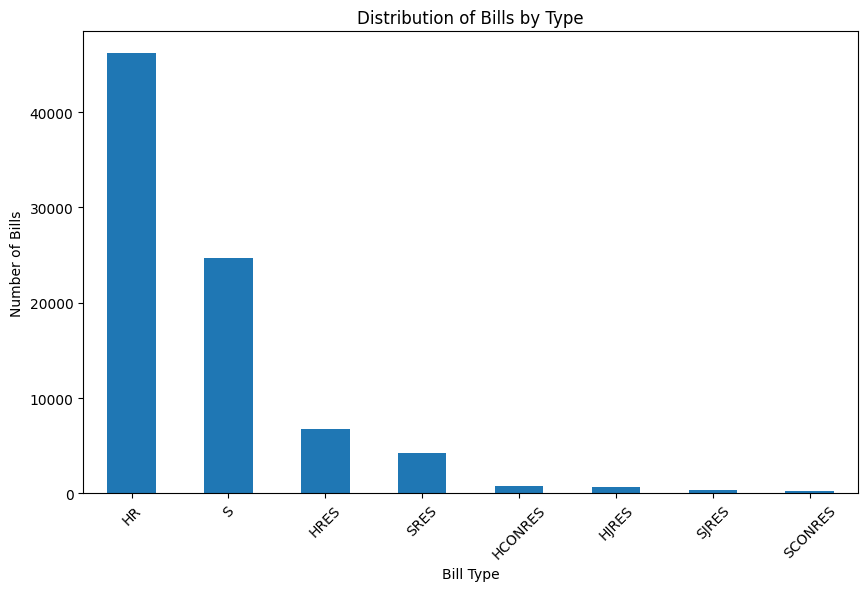

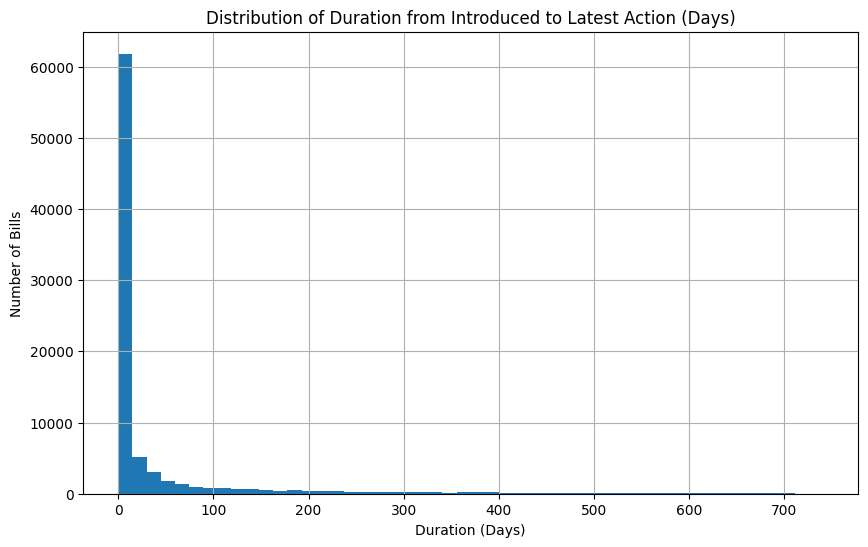

Most Common Cosponsors:
N000147    8470
G000551    5309
C001068    5240
L000551    5188
M000312    5125
S001145    4590
B000574    4359
J000032    4321
P000607    4084
B001277    4055
Name: count, dtype: int64


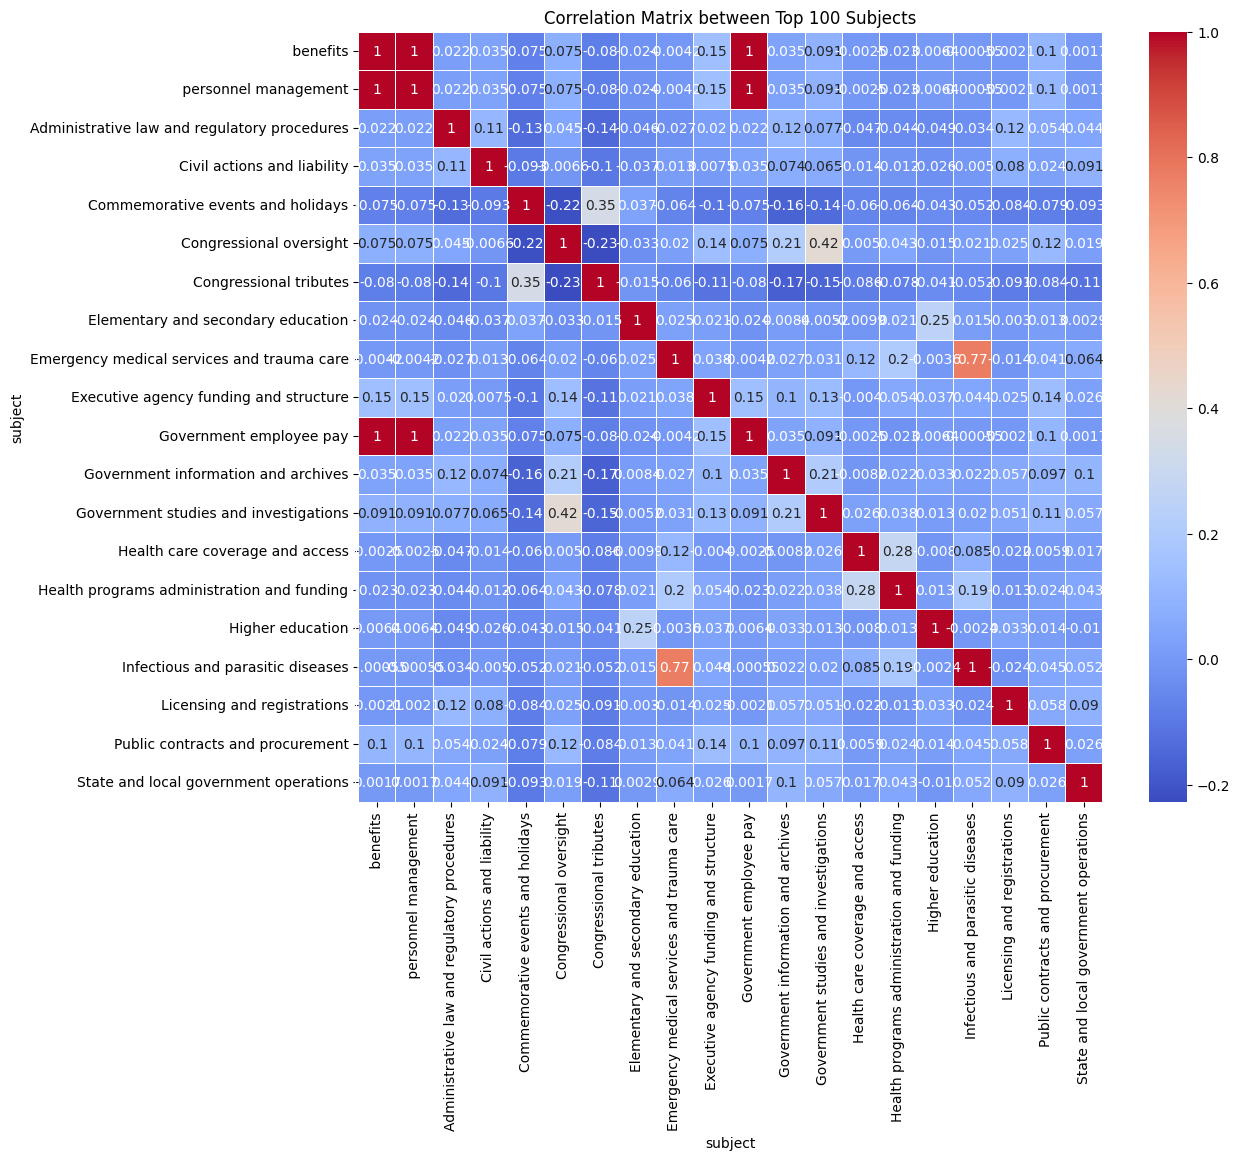

In [7]:
conn = sqlite3.connect("data/bill_data.db")
cursor = conn.cursor()

# Fetch required fields from bills
query = """
SELECT bill_congress, bill_type, introduced_date, latest_action_date, cosponsors, subjects
FROM bills
"""
cursor.execute(query)
data = cursor.fetchall()

# Convert fetched data into a pandas DataFrame for easier manipulation
df = pd.DataFrame(data, columns=['congress', 'bill_type', 'introduced_date', 'latest_action_date', 'cosponsors', 'subjects'])

# Close the connection now that we've fetched the data
conn.close()

# Convert dates from string to datetime format for calculation
df['introduced_date'] = pd.to_datetime(df['introduced_date'])
df['latest_action_date'] = pd.to_datetime(df['latest_action_date'])

# Calculate the duration from introduced_date to latest_action_date
df['duration_days'] = (df['latest_action_date'] - df['introduced_date']).dt.days

# Convert cosponsors and subjects to lists and filter out Unknown
df['cosponsors'] = df['cosponsors'].apply(lambda x: x.split(',') if x != 'Unknown' else [])
df['subjects'] = df['subjects'].apply(lambda x: x.split(',') if x != 'Unknown' else [])

# Plot distribution of congress
plt.figure(figsize=(10, 6))
df['congress'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Bills by Congress')
plt.xlabel('Congress')
plt.ylabel('Number of Bills')
plt.xticks(rotation=45)
plt.show()

# Plot distribution of bill types
plt.figure(figsize=(10, 6))
df['bill_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Bills by Type')
plt.xlabel('Bill Type')
plt.ylabel('Number of Bills')
plt.xticks(rotation=45)
plt.show()

# Histogram of duration days
plt.figure(figsize=(10, 6))
df['duration_days'].hist(bins=50)
plt.title('Distribution of Duration from Introduced to Latest Action (Days)')
plt.xlabel('Duration (Days)')
plt.ylabel('Number of Bills')
plt.show()

# Most common cosponsors
cosponsor_counts = pd.Series([cosponsor for cosponsors in df['cosponsors'] for cosponsor in cosponsors]).value_counts()
print("Most Common Cosponsors:")
print(cosponsor_counts.head(10))

# Most common subjects
subject_counts = pd.Series([subject for subjects in df['subjects'] for subject in subjects]).value_counts()
top_subjects = subject_counts.head(20).index

# Correlation matrix between top subjects
subject_dummies = df['subjects'].apply(lambda x: [subject for subject in x if subject in top_subjects]).apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('subject')
subject_dummies['value'] = 1
subject_matrix = subject_dummies.pivot_table(index=subject_dummies.index, columns='subject', values='value', fill_value=0)
correlation_matrix = subject_matrix.corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix between Top 100 Subjects')
plt.show()